<a href="https://colab.research.google.com/github/stevengregori92/ClusteringIntro/blob/main/Students_Performence_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kmodes

In [2]:
!pip install luwiji

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

#Import Dataset

In [4]:
!gdown https://drive.google.com/uc?id=1E6Rw_q5bRJBdxNAHLOtQMuDc5jpPc8j_

Downloading...
From: https://drive.google.com/uc?id=1E6Rw_q5bRJBdxNAHLOtQMuDc5jpPc8j_
To: /content/studentperform.zip
100% 49.7k/49.7k [00:00<00:00, 139MB/s]


In [5]:
!unzip /content/studentperform.zip

Archive:  /content/studentperform.zip
replace Student_Performance.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
df = pd.read_csv('Student_Performance.csv')
pd.options.display.max_columns=50
df

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0
...,...,...,...,...,...,...
9995,1,49,Yes,4,2,23.0
9996,7,64,Yes,8,5,58.0
9997,6,83,Yes,8,5,74.0
9998,9,97,Yes,7,0,95.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  object 
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 468.9+ KB


#Cleaning Dataset

,missing_value,%
Hours Studied,0,0.0
Previous Scores,0,0.0
Extracurricular Activities,0,0.0
Sleep Hours,0,0.0
Sample Question Papers Practiced,0,0.0
Performance Index,0,0.0


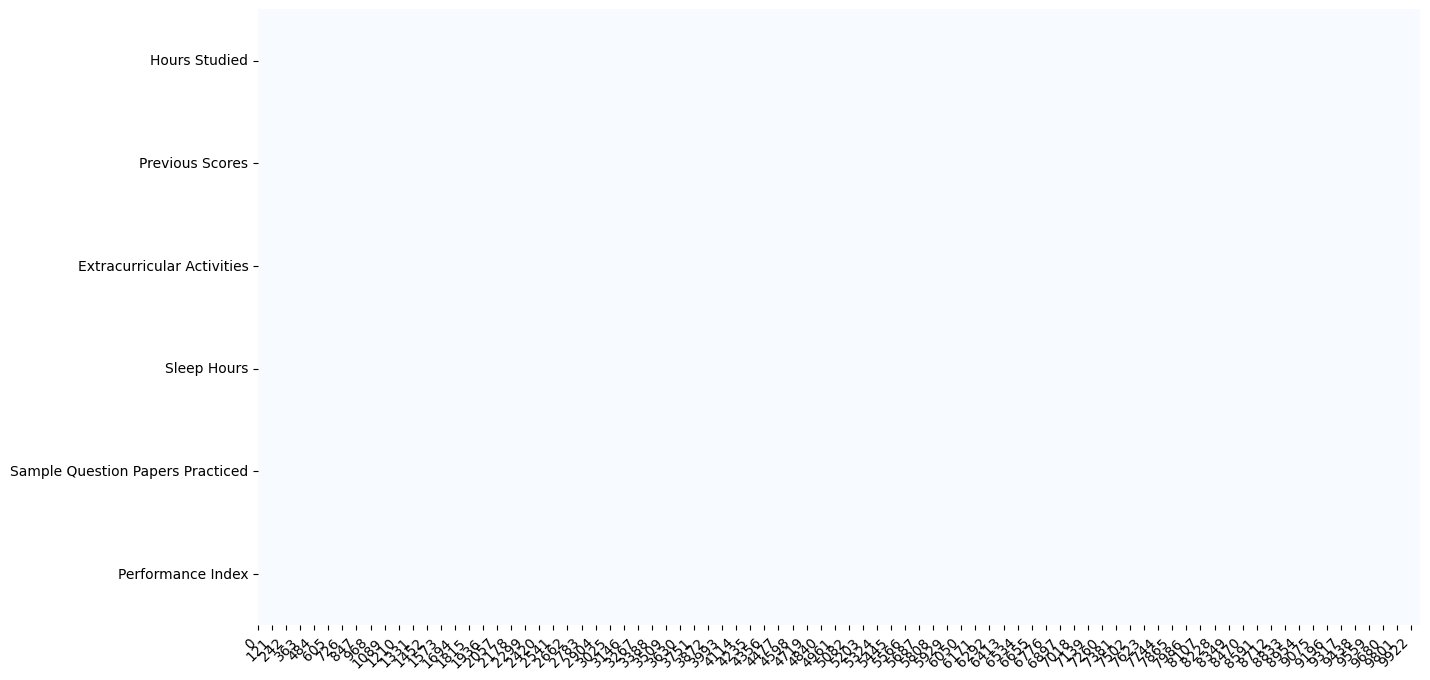

In [8]:
plot_missing_value(df, return_df=True)

In [9]:
df['Extracurricular Activities'] = df['Extracurricular Activities'].replace(['No', 'Yes'], [0,1])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Hours Studied                     10000 non-null  int64  
 1   Previous Scores                   10000 non-null  int64  
 2   Extracurricular Activities        10000 non-null  int64  
 3   Sleep Hours                       10000 non-null  int64  
 4   Sample Question Papers Practiced  10000 non-null  int64  
 5   Performance Index                 10000 non-null  float64
dtypes: float64(1), int64(5)
memory usage: 468.9 KB


#Define Cluster

In [11]:
from kmodes.kprototypes import KPrototypes
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

  0%|          | 0/3 [00:00<?, ?it/s]

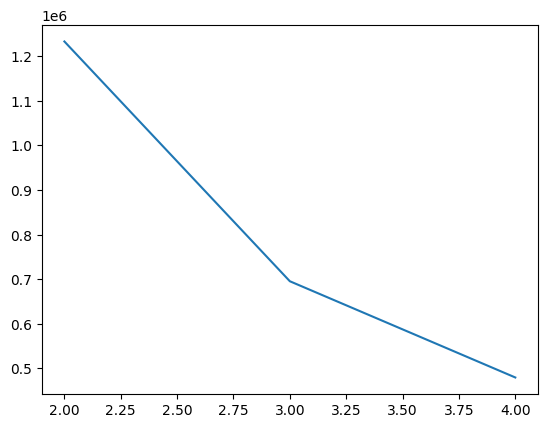

In [12]:
score=[]
for k in tqdm(range(2, 5)):
  model = KPrototypes(n_clusters=k)
  model.fit(df, categorical=[0,1])
  score.append(model.cost_)
plt.plot(range(2, 5), score)

#Training Clustering

In [13]:
model = KPrototypes(n_clusters=3)
member = model.fit_predict(df, categorical=[0,1])

In [14]:
df_pred = df.copy()
df_pred['cluster'] = member
df_pred.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index,cluster
0,7,99,1,9,1,91.0,0
1,4,82,0,4,2,65.0,1
2,8,51,1,7,2,45.0,1
3,5,52,1,5,2,36.0,2
4,7,75,0,8,5,66.0,1


#Dataset Splitting

In [15]:
X = df_pred.drop(columns=['Performance Index'])
y = df_pred['Performance Index']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 6), (2000, 6), (8000,), (2000,))

#Training

In [16]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [17]:
df_pred.iloc[0:2]

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index,cluster
0,7,99,1,9,1,91.0,0
1,4,82,0,4,2,65.0,1


In [18]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['Hours Studied','Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced']),
    ('categoric', cat_pipe(), ['Extracurricular Activities', 'cluster'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter = 50, n_jobs=-1, verbose=1, random_state = 42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.7048235217656795, 'algo__gamma': 3, 'algo__learning_rate': 0.08534852819566893, 'algo__max_depth': 6, 'algo__n_estimators': 157, 'algo__reg_alpha': 2.7645119606152053, 'algo__reg_lambda': 0.010023177978572915, 'algo__subsample': 0.3194173672147116}
0.9911642647304603 0.9887507561729523 0.9893670513239647
